# Import Modules

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import openpyxl
import datetime
from dateutil import parser

In [2]:
OPENAI_API_KEY = ""
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

In [3]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.schema import HumanMessage

# User-Defined Functions

In [4]:
# Read Raw data downloded in excel format
def read_raw_data (excel_file_name: str) -> pd.DataFrame:
    try:
        df = pd.read_excel(
            excel_file,
            parse_dates=[0],           # Parse first column as datetime
            dtype={1: 'Int64'},        # Safely handle large integers
            engine='openpyxl',         # Use openpyxl for .xlsx files    
        )
        #print(df.head(5))
    
    except Exception as e:
        print("Error reading Excel file:", e)

    return df

In [5]:
# Function to get sentiment using LangChain
def get_sentiment_with_langchain (text: str) -> str:
    prompt = prompt_template.format(text=text)
    try:
        response = llm([HumanMessage(content=prompt)])
        return response.content.strip()
    except Exception as e:
        print("Error processing:", text, "\n", e)
        return "Error"

In [6]:
def compute_sentiments (df: pd.DataFrame, text_sentiment_map: dict) -> pd.DataFrame:
    for text_key in text_sentiment_map.keys():
        print(text_key, text_sentiment_map[text_key])
        df[text_sentiment_map[text_key]] = df[text_key].apply(get_sentiment_with_langchain)

    return df

In [7]:
def visualize_sentiments (df: pd.DataFrame, text_sentiment_map: dict) -> None:
    num_text_types = len(text_sentiment_map.keys())
    fig, axes = plt.subplots(1, num_text_types, figsize=(12, 6))
    for sent_type_count, text_key in enumerate(text_sentiment_map.keys()):
        #print(text_key, text_sentiment_map[text_key])
        counts_sent = df[text_sentiment_map[text_key]].value_counts()
        axes[sent_type_count].pie(counts_sent, labels=counts_sent.index, autopct="%1.1f%%", startangle=90)
        axes[sent_type_count].set_title(text_key)
    
    plt.suptitle("Sentiment Distributions Across Text Columns", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [8]:
def reduce_df_to_a_sentiment (df_orig: pd.DataFrame, text_sentiment_map: dict, desired_sentiment: str) -> pd.DataFrame:
    df = df_orig.copy()
    for text_key in text_sentiment_map.keys():
        #print(text_key, text_sentiment_map[text_key])
        df = df [df[text_sentiment_map[text_key]] == desired_sentiment]

    return df
    

In [9]:
# Function to extract keywords and counts using OpenAI
def extract_keywords_with_counts(llm, prompt_template, text: str):
    prompt = prompt_template.format(text=text[:4000])  # truncate if needed
    response = llm([HumanMessage(content=prompt)])
    
    # Parse response into dict
    result = {}
    for line in response.content.strip().split("\n"):
        if ":" in line:
            try:
                key, val = line.split(":")
                result[key.strip()] = int(val.strip())
            except ValueError:
                continue
    return result

In [10]:
def extract_frequent_words_for_sentiment (df_orig, text_sentiment_map, desired_sentiment, llm, prompt_template, freq_words_collection):
    # Reduce the data frame so that each text column has the same sentiment type
    #df = reduce_df_to_a_sentiment (df_orig, text_sentiment_map, desired_sentiment)
    
    for sent_type_count, text_key in enumerate(text_sentiment_map.keys()):
        #print(text_key, text_sentiment_map[text_key])
        df = df_orig [df_orig[text_sentiment_map[text_key]] == desired_sentiment]
        col = text_key
        text = " ".join(df[col].dropna().astype(str).tolist())
        result = extract_keywords_with_counts(llm, prompt_template, text)
        
        freq_words_collection[text_key][desired_sentiment] = result
    
        print(f"\nTop 10 keywords from column '{col}' that represent '{desired_sentiment}' sentiments:")
        for k, v in result.items():
            print(f"{k}: {v}")

    return freq_words_collection

In [32]:
def visualize_frequent_words_for_sentiment (freq_words_collection):
    
    sentiment_colors = {
    'Positive': 'green',
    'Neutral': 'gray',
    'Negative': 'red'
    }

    # Create subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6), sharey=False)
    fig.suptitle("Top Keywords by Sentiment for Each Text Source", fontsize=16, fontweight='bold')
    
    for ax, (source, sentiments) in zip(axes, freq_words_collection.items()):
        ax.set_title(f"{source.replace('_', ' ').title()}")
        all_words = []
        all_counts = []
        all_colors = []
    
        for sentiment, words in sentiments.items():
            for word, count in words.items():
                all_words.append(word)
                all_counts.append(count)
                all_colors.append(sentiment_colors.get(sentiment, 'black'))
    
        # Plot histogram
        ax.barh(all_words, all_counts, color=all_colors)
        ax.invert_yaxis()  # Highest count at top
        ax.set_xlabel("Frequency")
        ax.set_ylabel("Words")
        ax.grid(axis='x', linestyle='--', alpha=0.7)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Read the Raw Data

In [11]:
excel_file = 'engagements.xlsx'
df = read_raw_data(excel_file)
df.head(5)

,timestamp,media_id,media_caption,comment_text
0,2025-03-01 00:13:57.153000+00:00,1090986906404998,"Soft skin, soft life 🩷🌸🫧 get your hands on thi...",I bet this is good
1,2025-03-01 00:23:06.879000+00:00,17950254656929862,Why use one scrub when you can use them all at...,i know this smells so good
2,2025-03-01 00:04:05.094000+00:00,1090109319826090,Morning routine with Tree Hut 🍊🫧 Now available...,Love it
3,2025-03-01 00:41:59.467000+00:00,1098364052333950,Why use one scrub when you can use them all at...,Please carry these in Canada! I miss them so m...
4,2025-03-01 02:21:29.715000+00:00,1083943630442659,Vanilla Serum-Infused Hand Wash: A sweet escap...,I love it ..✌️


# Proceed with a subset for Testing

In [12]:
##
#n_rows = len(df)
df = df.iloc[::500]

In [13]:
len(df)

36

# Define LLM

In [14]:
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0.0)

/tmp/ipykernel_1348363/1554941544.py:1: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0.0)


# Analyze Sentiments

### Define a prompt template

In [15]:
prompt_template = PromptTemplate.from_template(
    "Classify the sentiment of the following text as Positive, Negative, or Neutral:\n\n{text}\n\nSentiment:"
)

### Define a map between column names with text and the corresponding sentiment

In [16]:
text_sentiment_map = {
    'media_caption': 'sentiment_media_caption',
    'comment_text': 'sentiment_comment_text',
    #'comment_text2': 'sentiment_comment_text2'
}

In [17]:
text_sentiment_map

{'media_caption': 'sentiment_media_caption',
 'comment_text': 'sentiment_comment_text'}

In [18]:
#df['media_caption'][0]

In [19]:
#get_sentiment_with_langchain(df['media_caption'][0])

### Compute Sentiments

In [20]:
df = compute_sentiments (df, text_sentiment_map)
df_orig = df.copy()

media_caption sentiment_media_caption


/tmp/ipykernel_1348363/4098399969.py:5: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = llm([HumanMessage(content=prompt)])


comment_text sentiment_comment_text


In [21]:
df

,timestamp,media_id,media_caption,comment_text,sentiment_media_caption,sentiment_comment_text
0,2025-03-01 00:13:57.153000+00:00,1090986906404998,"Soft skin, soft life 🩷🌸🫧 get your hands on thi...",I bet this is good,Positive,Positive
500,2025-03-06 07:05:10.771000+00:00,1098549352315420,Run to get my fave for a year-round summer ski...,Bought,Positive,Neutral
1000,2025-03-10 20:27:33.787000+00:00,18059074886050845,✨🌴SPRING BREAK GIVEAWAY 🌴✨\n\nWith spring brea...,@andenewman76,Positive,Neutral
1500,2025-03-11 11:45:09.476000+00:00,18059074886050845,✨🌴SPRING BREAK GIVEAWAY 🌴✨\n\nWith spring brea...,@rxmo0402,Positive,Neutral
2000,2025-03-13 19:32:42.850000+00:00,18059074886050845,✨🌴SPRING BREAK GIVEAWAY 🌴✨\n\nWith spring brea...,@angellov3_03,Positive,Neutral
2500,2025-03-17 21:57:44.086000+00:00,18051403259269591,"Ready to wake up to soft, hydrated lips? 💋✨ \n...",@oreolaura_,Positive,Neutral
3000,2025-03-21 15:22:22.374000+00:00,18036343751267796,APPLICATIONS ARE NOW CLOSED! 🚨 \nThank you to ...,Treehut PR,Positive,Neutral
3500,2025-03-21 16:18:20.293000+00:00,18036343751267796,APPLICATIONS ARE NOW CLOSED! 🚨 \nThank you to ...,trent pr!!,Positive,Positive
4000,2025-03-21 17:47:44.278000+00:00,18036343751267796,APPLICATIONS ARE NOW CLOSED! 🚨 \nThank you to ...,Treehut PR!,Positive,Positive
4500,2025-03-21 21:05:11.605000+00:00,18036343751267796,APPLICATIONS ARE NOW CLOSED! 🚨 \nThank you to ...,Treehut PR 😍,Positive,Positive


### Visualize Sentiments

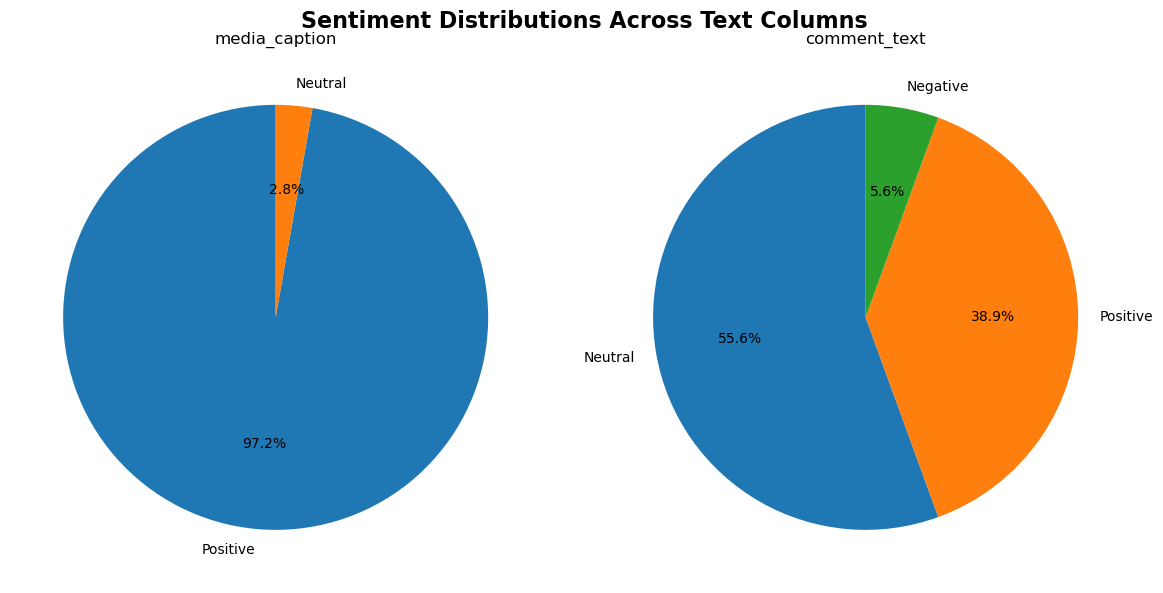

In [22]:
visualize_sentiments (df, text_sentiment_map)

# Obtain frequent words for each type of sentiment

### Define a prompt template

In [23]:
prompt_template = PromptTemplate.from_template(
    """Extract the top 10 most important keywords or phrases from the following text, and show how often each one appears. 
Return them in the format: keyword: count, one per line. Only include meaningful content words, not stopwords or punctuation.

Text:
{text}
"""
)

In [24]:
freq_words_collection = dict()
for text_key in text_sentiment_map.keys():
    #print(text_key, text_sentiment_map[text_key])
    freq_words_collection[text_key] = dict()
        

In [25]:
freq_words_collection

### Call function

In [26]:
freq_words_collection = extract_frequent_words_for_sentiment (df_orig, text_sentiment_map, 'Positive', llm, prompt_template, freq_words_collection)


Top 10 keywords from column 'media_caption' that represent 'Positive' sentiments:
spring break: 6
giveaway: 6
treehut: 6
selfcare: 4
skin: 3
smooth: 3
glowing: 3
winners: 3
shop: 3
essential: 3

Top 10 keywords from column 'comment_text' that represent 'Positive' sentiments:
treehut: 4
pr: 3
love: 2
good: 1
stuff: 1
strawberry: 1
scent: 1
dewy daisy: 1
alaina remmus: 1


In [27]:
freq_words_collection = extract_frequent_words_for_sentiment (df_orig, text_sentiment_map, 'Negative', llm, prompt_template, freq_words_collection)


Top 10 keywords from column 'media_caption' that represent 'Negative' sentiments:

Top 10 keywords from column 'comment_text' that represent 'Negative' sentiments:
website: 1
hope: 1
food: 1
joke: 1


In [28]:
freq_words_collection = extract_frequent_words_for_sentiment (df_orig, text_sentiment_map, 'Neutral', llm, prompt_template, freq_words_collection)


Top 10 keywords from column 'media_caption' that represent 'Neutral' sentiments:
espresso: 1

Top 10 keywords from column 'comment_text' that represent 'Neutral' sentiments:
Treehut: 10
PR: 7
@andenewman76: 1
@rxmo0402: 1
@angellov3_03: 1
@oreolaura_: 1
@lexie.770: 1
@_kayaker: 1
@keniaquisi: 1
Michelle: 1


### Visualize

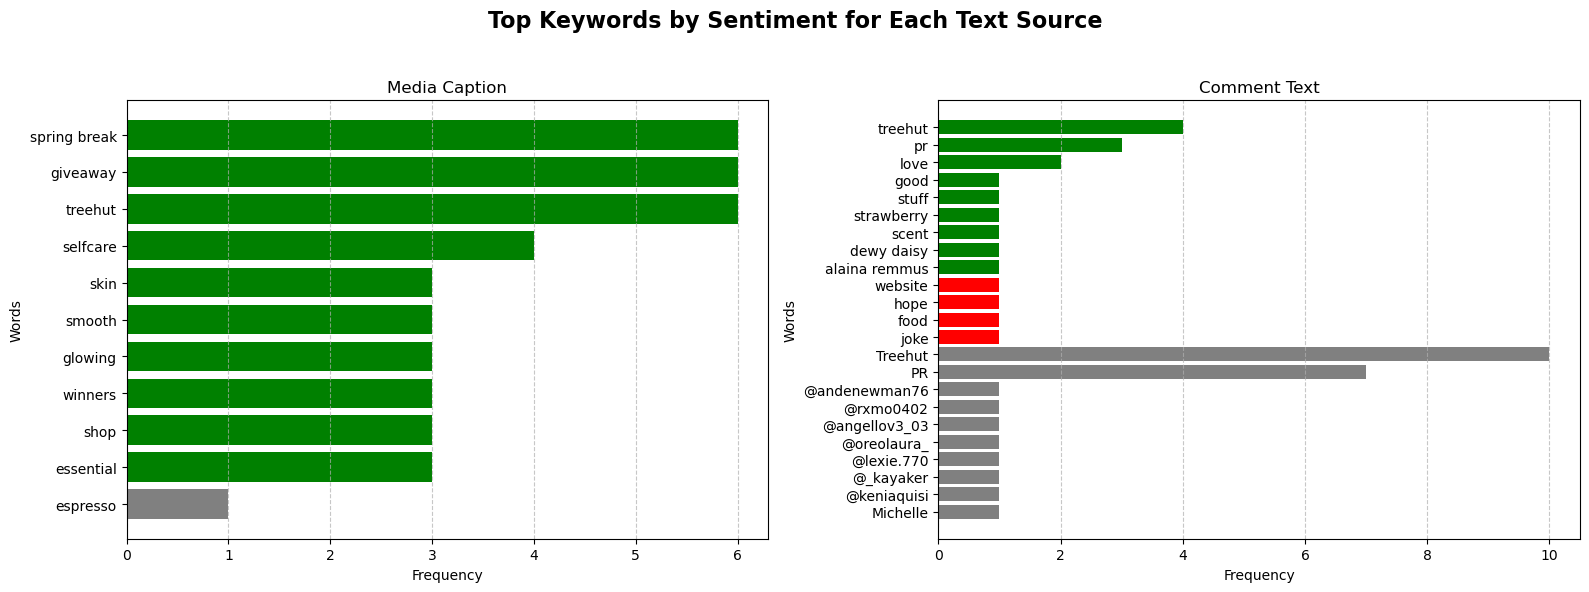

In [33]:
visualize_frequent_words_for_sentiment (freq_words_collection)